In [1]:
from pyNA.pyna import pyna
import openmdao.api as om

In [2]:
settings = dict()
settings['pyna_directory'] = '..'
settings['case_name'] = 'nasa_stca_standard'
settings['engine_deck_file_name'] = 'engine_deck_stca.csv'
settings['n_frequency_bands'] = 24
settings['n_frequency_subbands'] = 5
settings['fan_inlet_source'] = True
settings['fan_discharge_source'] = True
settings['core_source'] = True
settings['jet_mixing_source'] = True
settings['jet_shock_source'] = True
settings['airframe_source'] = True
settings['core_turbine_attenuation_method'] = 'ge'
settings['atmosphere_type'] = 'stratified'
settings['thrust_lapse'] = True
settings['F00'] = None

settings['output_directory_name'] = '.'
settings['time_history_file_name'] = 'time_history.csv'



In [3]:
py = pyna(settings=settings)

In [4]:
py.trajectory.compute_path(py.settings)

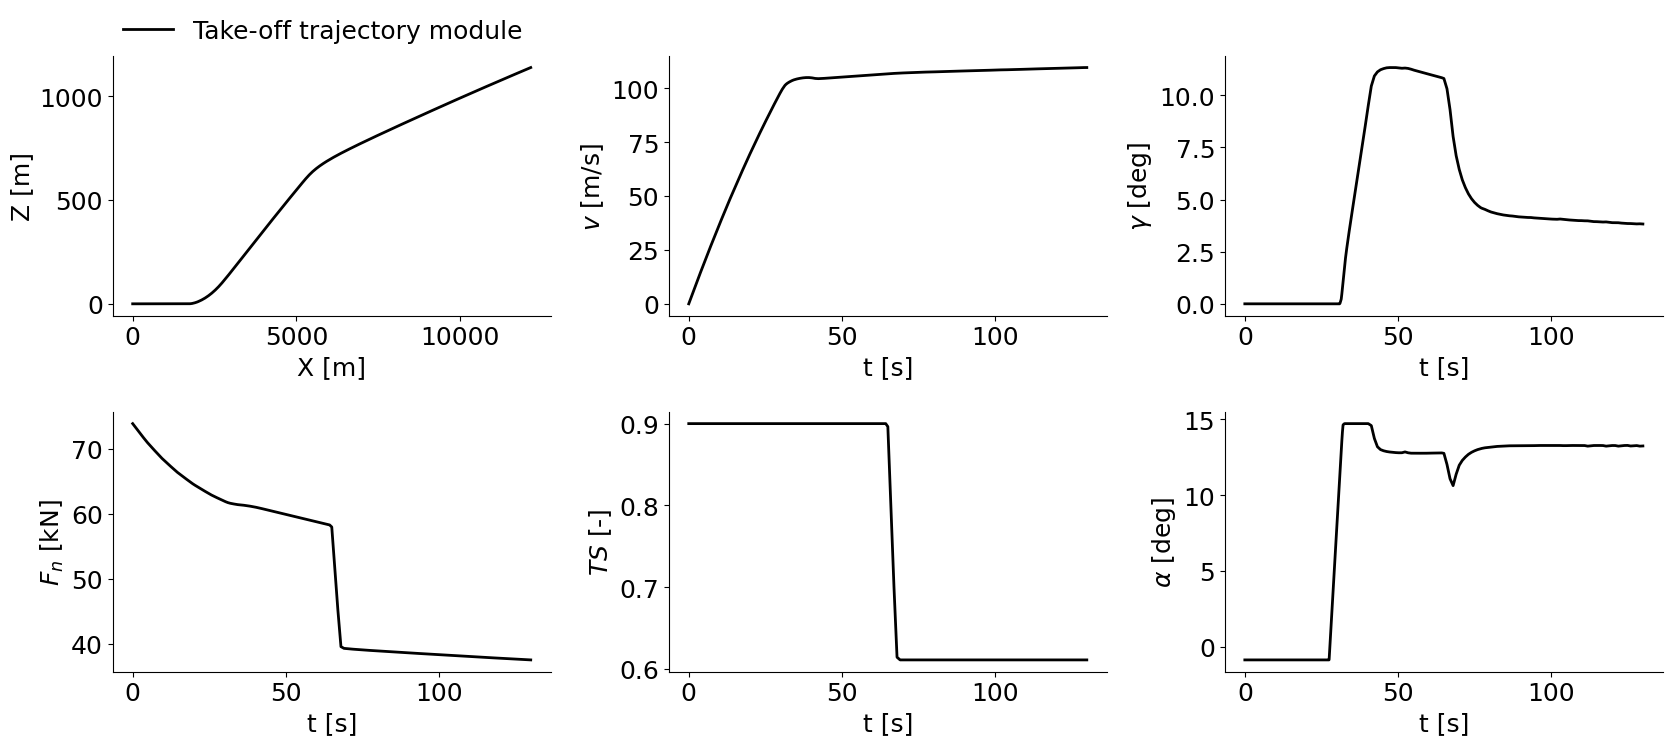

In [8]:
py.trajectory.plot_path()

In [6]:
prob = om.Problem()
C1 = prob.model.add_subsystem('C1', om.ExecComp('x = a + b'))
prob.setup()
prob.set_solver_print(level=0)
prob.run_model()


In [7]:
om.n2(prob)